___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

# WELCOME!

Welcome to ***"Demand Prediction Project"***. This is the third capstone project.
As you know recently, free or affordable access to bicycles has been provided for short-distance trips in an urban area as an alternative to motorized public transport or private vehicles. Thus, it is aimed to reduce traffic congestion, noise and air pollution.

In this project, the goal is to predict the number of future bike shares given the historical data of London bike shares. So this case should be handled as a time series problem with ***Bidirectional LSTM***. 

In order to achieve this goal, you will make predictions with LSTM, unlike the machine learning algorithms you have applied before. Long short term memory (LSTM) is an artificial repetitive neural network architecture used in the field of deep learning. Unlike standard feed forward neural networks, LSTM has feedback links. It can process not only single data points but also entire data series. 

Before diving into the project, please take a look at the Determines and Tasks.

- **NOTE:** This tutorial assumes that you already know the basics of coding in Python and are familiar with the theory behind LSTM.



---
---

# #Determines

#### Features

- timestamp - timestamp field for grouping the data
- cnt - the count of a new bike shares
- t1 - real temperature in C
- t2 - temperature in C “feels like”
- hum - humidity in percentage
- wind_speed - wind speed in km/h
- weather_code - category of the weather
- is_holiday - boolean field - 1 holiday / 0 non holiday
- is_weekend - boolean field - 1 if the day is weekend
- season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.


---

Initially, the task of discovering data will be waiting for you as always. Recognize features, detect missing values, outliers etc.

Review the data from various angles in different time breakdowns. For example, visualize the distribution of bike shares by day of the week. With this graph, you will be able to easily observe and make inferences how people's behavior changes daily. Likewise, you can make hourly, monthly, seasonally etc. analyzes. In addition, you can analyze correlation of variables with a heatmap.

In the Pre-Processing task after train test split and robust scaling, the challenge for you will be to divide the data into time steps and transform it into a three dimentional numpy array.

Then in the model building task, build your model appropriate and compare the train and validation losses using a graph. 

When making prediction, you will need to do the inverse transform process to get a true error score. Otherwise, the results you get with scaled target variables may mislead you.

Finally, Visualize how well your model's predictions match the actual values of the test data and also calculate error scores.


- ***Note:*** *What you can do in this project is more than what is asked of you.*


# #Tasks

#### 1. Exploratory Data Analysis

- Check Missing Values and Outliers
- Plot Breakdowns of Data

    *i.  Plot bike shares over time*
    
    *ii.  Plot bike shares by months*
    
    *iii. Plot bike shares by hours*
    
    *iv. Plot bike shares by day of week*
    
    *v. Plot the distribution of bike shares on holidays by seasons*
    
- Drop unnecessary columns
    
#### 2. Data Pre-Processing

- Train - Test Split
- Scaling
- Define a Function for Creating Time Steps

#### 3. Model Building with LSTM

- Create, Compile and Fit Bidirectional LSTM Model
- Plot Train and Validation Losses

#### 4. Demand Prediction and Calculate Scores

- Inverse Transform
- Plot Prediction


## Improt Libraries and Indest Data

In [233]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

## Some Useful User Defined Functions

In [234]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop related columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
        
###############################################################################

In [235]:
df = pd.read_csv("store_sharing.csv")

# df = pd.read_csv("store_sharing.csv",
#                    index_col='DATE',
#                    parse_dates=True)

In [236]:
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)

Shape:(17414, 10)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB
None
-------------------------------------------------------------------------------
Number of Uniques:
timestamp       17414
cnt              3781
t1                 73
t2                 82
hum             

In [237]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.000,2.000,93.000,6.000,3.000,0.000,1.000,3.000
1,2015-01-04 01:00:00,138,3.000,2.500,93.000,5.000,1.000,0.000,1.000,3.000
2,2015-01-04 02:00:00,134,2.500,2.500,96.500,0.000,1.000,0.000,1.000,3.000
3,2015-01-04 03:00:00,72,2.000,2.000,100.000,0.000,1.000,0.000,1.000,3.000
4,2015-01-04 04:00:00,47,2.000,0.000,93.000,6.500,1.000,0.000,1.000,3.000


In [238]:
df.tail()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
17409,2017-01-03 19:00:00,1042,5.000,1.000,81.000,19.000,3.000,0.000,0.000,3.000
17410,2017-01-03 20:00:00,541,5.000,1.000,81.000,21.000,4.000,0.000,0.000,3.000
17411,2017-01-03 21:00:00,337,5.500,1.500,78.500,24.000,4.000,0.000,0.000,3.000
17412,2017-01-03 22:00:00,224,5.500,1.500,76.000,23.000,4.000,0.000,0.000,3.000
17413,2017-01-03 23:00:00,139,5.000,1.000,76.000,22.000,2.000,0.000,0.000,3.000


In [239]:
df.sample(5)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
9695,2016-02-14 03:00:00,92,4.000,2.000,90.000,7.000,7.000,0.000,1.000,3.000
3326,2015-05-22 22:00:00,801,18.000,18.000,68.000,8.000,3.000,0.000,0.000,0.000
7980,2015-12-04 05:00:00,92,8.000,5.000,73.500,20.000,1.000,0.000,0.000,3.000
14653,2016-09-10 21:00:00,563,18.000,18.000,88.000,12.000,3.000,0.000,1.000,2.000
8270,2015-12-16 11:00:00,857,15.000,15.000,77.000,25.000,3.000,0.000,0.000,3.000


---
---

## 1. Exploratory Data Analysis

- Firstly, focus data based on the timestamp. You can create various variables such as, hour, day of week, day of month etc.
- You can check missing values and outliers.
- Also you can plot breakdowns of data.

#### 1. Exploratory Data Analysis

- Check Missing Values and Outliers
- Plot Breakdowns of Data

    *i.  Plot bike shares over time*
    
    *ii.  Plot bike shares by months*
    
    *iii. Plot bike shares by hours*
    
    *iv. Plot bike shares by day of week*
    
    *v. Plot the distribution of bike shares on holidays by seasons*
    
- Drop unnecessary columns

### Check Missing Values and Outliers

- Firstly, focus data based on the timestamp. You can create various variables such as, hour, day of week, day of month etc.

In [240]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace = True)

df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.000,2.000,93.000,6.000,3.000,0.000,1.000,3.000
2015-01-04 01:00:00,138,3.000,2.500,93.000,5.000,1.000,0.000,1.000,3.000
2015-01-04 02:00:00,134,2.500,2.500,96.500,0.000,1.000,0.000,1.000,3.000
2015-01-04 03:00:00,72,2.000,2.000,100.000,0.000,1.000,0.000,1.000,3.000
2015-01-04 04:00:00,47,2.000,0.000,93.000,6.500,1.000,0.000,1.000,3.000


In [241]:
from datetime import datetime

df["year_month"] = df.index.strftime('%Y-%m')
df["year"] = df.index.year
df["month"] = df.index.month
df["day_of_month"] = df.index.day
df["day_of_week"] = df.index.day_of_week
df["hour"] = df.index.hour

df.head(1)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year_month,year,month,day_of_month,day_of_week,hour
timestamp,,,,,,,,,,,,,,,
2015-01-04,182,3.000,2.000,93.000,6.000,3.000,0.000,1.000,3.000,2015-01,2015,1,4,6,0


In [242]:
duplicate_values(df)

Duplicate check...
There are no duplicates
-------------------------------------------------------------------------------


In [243]:
df.shape

(17414, 15)

- Since we created new columns from the timestamp column, we no longer need the year-month column. We can drop the year-month column.

In [244]:
# df.drop("year_month", axis = 1, inplace = True)

In [245]:
# df.head(1)

- Check Missing Values

In [246]:
# Function for determining the number and percentages of missing values

def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [247]:
missing (df)

,Missing_Number,Missing_Percent
cnt,0,0.000
t1,0,0.000
t2,0,0.000
hum,0,0.000
wind_speed,0,0.000
weather_code,0,0.000
is_holiday,0,0.000
is_weekend,0,0.000
season,0,0.000
year_month,0,0.000


- Check Outliers

In [248]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cnt,17414.000,1143.102,1085.108,0.000,257.000,844.000,1671.750,7860.000
t1,17414.000,12.468,5.572,-1.500,8.000,12.500,16.000,34.000
t2,17414.000,11.521,6.615,-6.000,6.000,12.500,16.000,34.000
hum,17414.000,72.325,14.313,20.500,63.000,74.500,83.000,100.000
wind_speed,17414.000,15.913,7.895,0.000,10.000,15.000,20.500,56.500
weather_code,17414.000,2.723,2.341,1.000,1.000,2.000,3.000,26.000
is_holiday,17414.000,0.022,0.147,0.000,0.000,0.000,0.000,1.000
is_weekend,17414.000,0.285,0.452,0.000,0.000,0.000,1.000,1.000
season,17414.000,1.492,1.119,0.000,0.000,1.000,2.000,3.000
year,17414.000,2015.508,0.508,2015.000,2015.000,2016.000,2016.000,2017.000


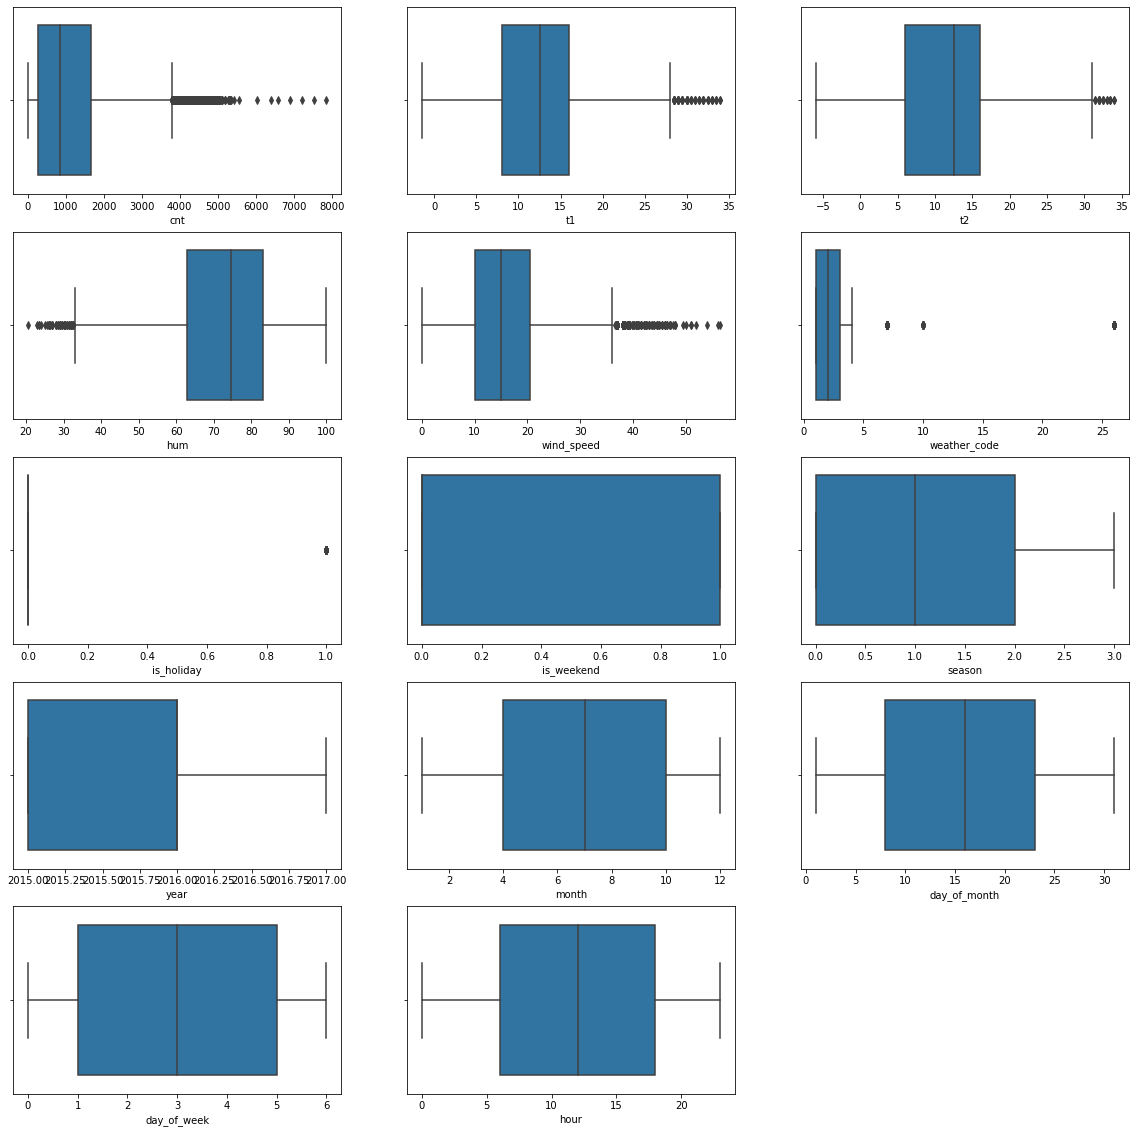

In [249]:
index = 0
plt.figure(figsize=(20,20))
for col in df.select_dtypes(include=[np.number]).columns[:14]:
    index += 1
    plt.subplot(5,3,index)
    sns.boxplot(x=col, data=df, whis=1.5)

In [250]:
# index = 0
# plt.figure(figsize = (20,20))
# for col in df.columns[:14]:
#     index += 1
#     plt.subplot(5,3,index)
#     sns.boxplot(y = col, x = "cnt", data = df, whis = 1.5)

### Plot Breakdowns of Data

***i. Plot bike shares over time***

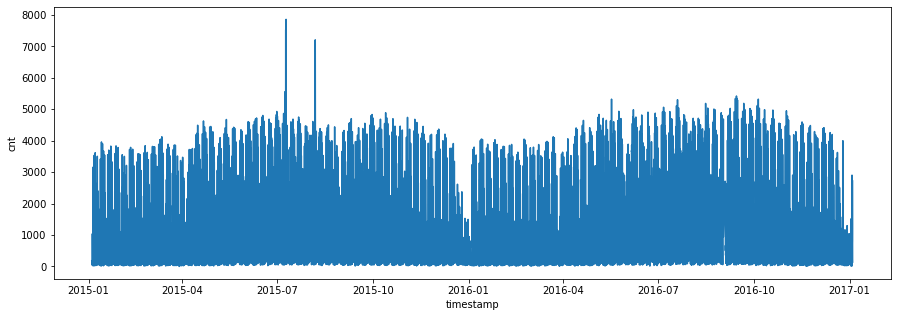

In [251]:
plt.figure(figsize=(15,5))
sns.lineplot(data = df, x = df.index, y = "cnt")

plt.show()

***ii. Plot bike shares by months***

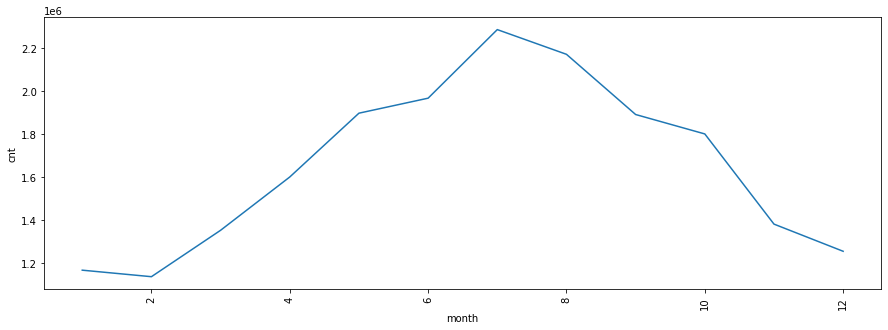

In [252]:
plt.figure(figsize = (15,5))
sns.lineplot(data = df, x = "month", y = "cnt", estimator = 'sum', ci = None)
plt.xticks(rotation = 90);

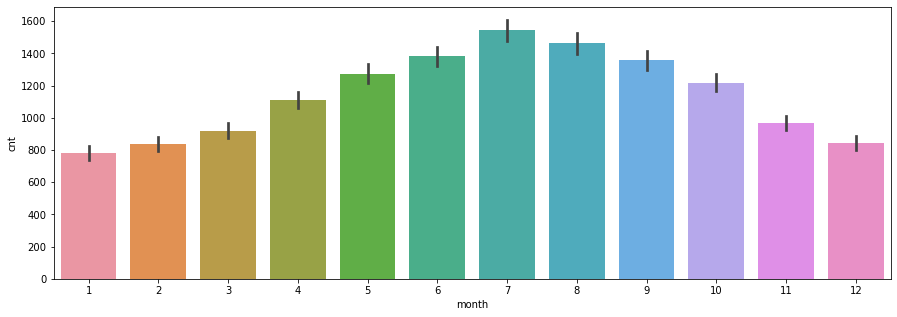

In [253]:
plt.figure(figsize=(15,5))
sns.barplot(data = df, x = "month", y = "cnt");

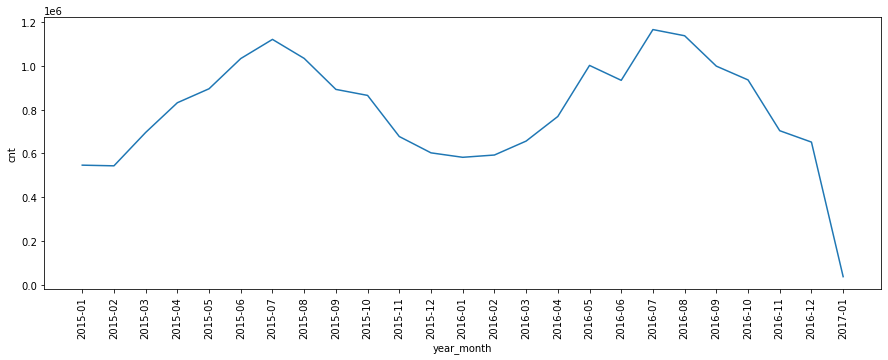

In [254]:
plt.figure(figsize = (15,5))

sns.lineplot(data = df, x = "year_month", y = "cnt", estimator = 'sum', ci = None)
plt.xticks(rotation = 90)

plt.show()

***iii. Plot bike shares by hours***
- *whether it is a holiday or not*
- *You may want to see seasonal breakdowns*

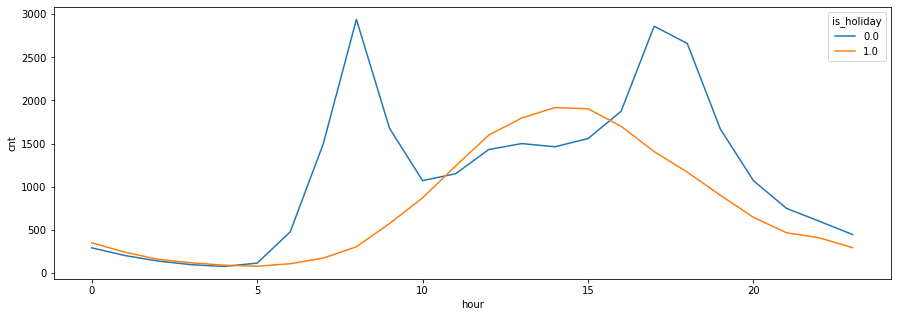

In [255]:
plt.figure(figsize = (15,5))
sns.lineplot(data = df, x = "hour", y = "cnt", hue = "is_holiday", ci = None)
plt.show()

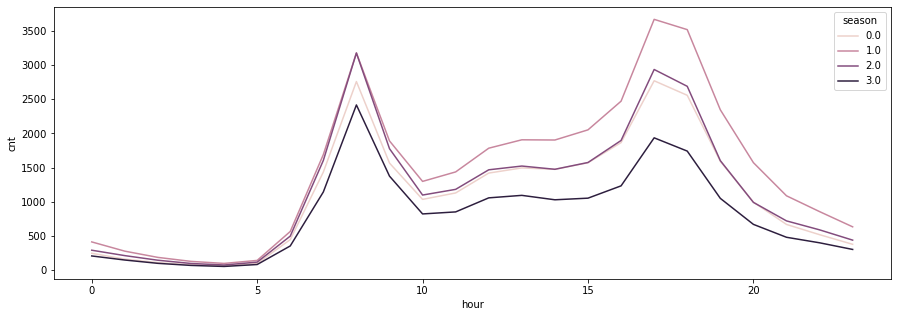

In [256]:
plt.figure(figsize = (15,5))
sns.lineplot(data = df, x = "hour", y = "cnt", hue = "season", ci = None)
plt.show()

***iv. Plot bike shares by day of week***
- *You may want to see seasonal breakdowns*

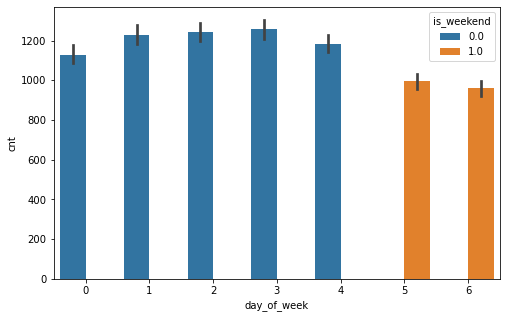

In [257]:
plt.figure(figsize = (8,5))
sns.barplot(data = df, x = "day_of_week", y = "cnt", hue = "is_weekend")
plt.show()

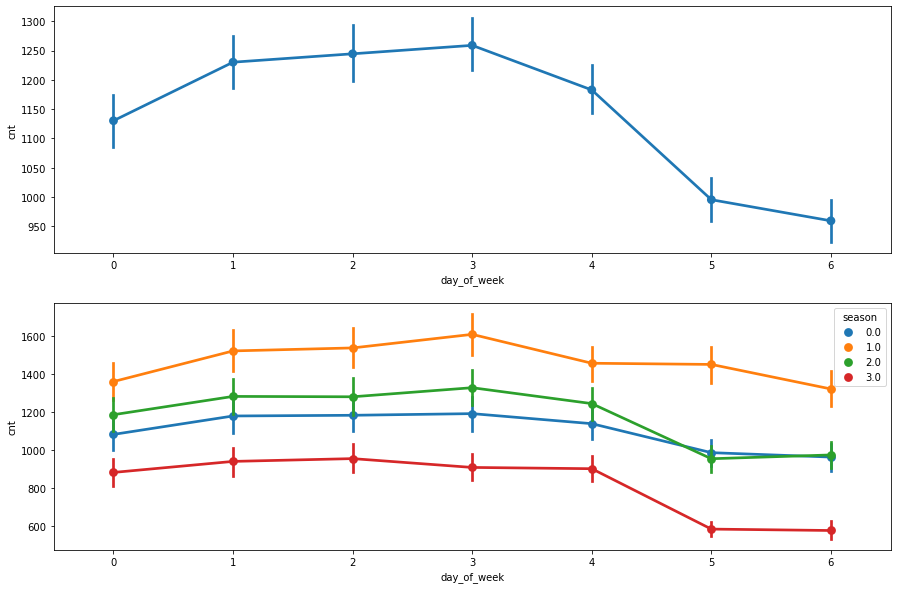

In [258]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15,10))
sns.pointplot(data = df, x = "day_of_week", y = "cnt", ax = ax[0])
sns.pointplot(data = df, x = "day_of_week", y = "cnt", hue = "season", ax = ax[1])
plt.show()

***v. Plot the distribution of bike shares on holidays by seasons***

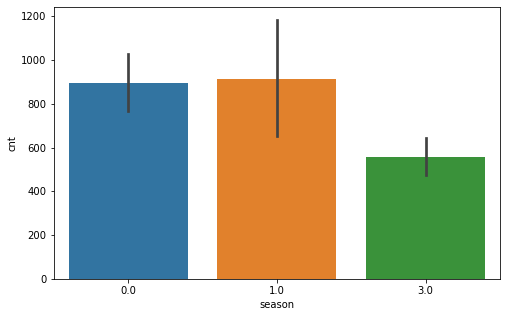

In [259]:
is_holiday = df[df.is_holiday == 1.0]

plt.figure(figsize = (8,5))
sns.barplot(data = is_holiday, x = "season", y = "cnt")
plt.show()

### Drop unnecessary columns

- Check correlations via heatmap
- Check weather_code
- Think about time-based features and decide dropping which is unnecessary for the model

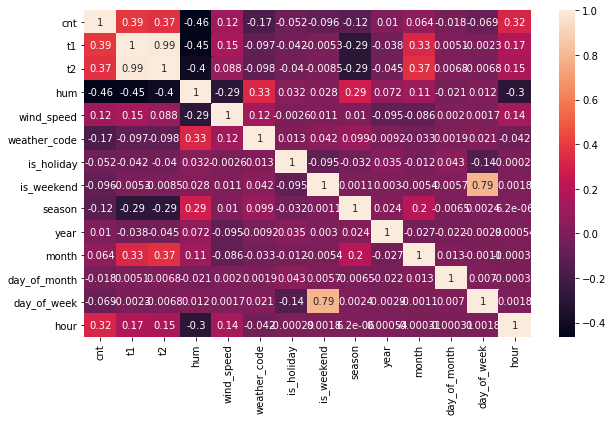

In [260]:
sns.heatmap(df.corr(), annot=True);

In [261]:
target_variable = round(df.corr().iloc[0].sort_values(), 3)
target_variable

hum            -0.463
weather_code   -0.167
season         -0.116
is_weekend     -0.096
day_of_week    -0.069
is_holiday     -0.052
day_of_month   -0.018
year            0.010
month           0.064
wind_speed      0.116
hour            0.324
t2              0.369
t1              0.389
cnt             1.000
Name: cnt, dtype: float64

In [262]:
target_variable.index

Index(['hum', 'weather_code', 'season', 'is_weekend', 'day_of_week',
       'is_holiday', 'day_of_month', 'year', 'month', 'wind_speed', 'hour',
       't2', 't1', 'cnt'],
      dtype='object')

In [263]:
target_variable.values

array([-0.463, -0.167, -0.116, -0.096, -0.069, -0.052, -0.018,  0.01 ,
        0.064,  0.116,  0.324,  0.369,  0.389,  1.   ])

In [264]:
target_variable_df = pd.DataFrame({"Cnt": target_variable.values},
                                    index = target_variable.index)

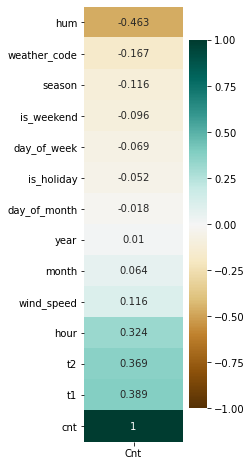

In [265]:
plt.figure(figsize=(2.2,8))

sns.heatmap(target_variable_df, vmin=-1, vmax=1, annot=True, fmt="g", cmap = 'BrBG')

plt.show()

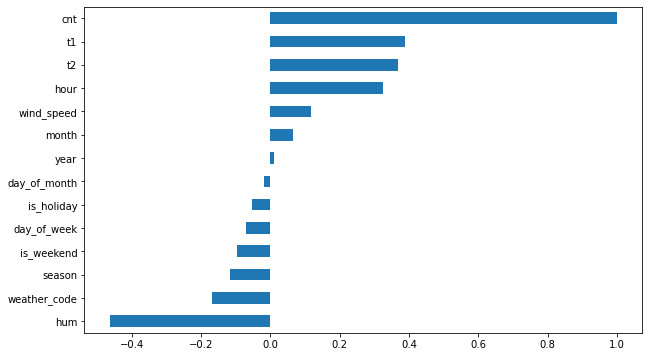

In [266]:
target_variable.plot(x = target_variable.index, y = target_variable.values, kind = "barh", figsize = (10,6));

In [267]:
df_temp = df.corr()

count = "Done"
feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> .9 and df_temp[col][i] < 1) or (df_temp[col][i]< -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                print(Fore.RED + f"\033[1mmulticolinearity alert in between\033[0m {col} - {i}")
        else:
            print(f"For {col} and {i}, there is NO multicollinearity problem") 

print("\033[1mThe number of strong corelated features:\033[0m", count) 

For cnt and cnt, there is NO multicollinearity problem
For cnt and t1, there is NO multicollinearity problem
For cnt and t2, there is NO multicollinearity problem
For cnt and hum, there is NO multicollinearity problem
For cnt and wind_speed, there is NO multicollinearity problem
For cnt and weather_code, there is NO multicollinearity problem
For cnt and is_holiday, there is NO multicollinearity problem
For cnt and is_weekend, there is NO multicollinearity problem
For cnt and season, there is NO multicollinearity problem
For cnt and year, there is NO multicollinearity problem
For cnt and month, there is NO multicollinearity problem
For cnt and day_of_month, there is NO multicollinearity problem
For cnt and day_of_week, there is NO multicollinearity problem
For cnt and hour, there is NO multicollinearity problem
For t1 and cnt, there is NO multicollinearity problem
For t1 and t1, there is NO multicollinearity problem
multicolinearity alert in between t1 - t2
For t1 and hum, there is NO m

- As seen from the heatmap and the output above, there is a high correlation between t1 and t2.
- t1 - real temperature in C
- t2 - temperature in C “feels like”
- We can drop t2 column.

"weather_code" category description:
- 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
- 2 = scattered clouds / few clouds 
- 3 = Broken clouds 
- 4 = Cloudy 
- 7 = Rain/ light Rain shower/ Light rain 
- 10 = rain with thunderstorm 
- 26 = snowfall 

In [268]:
df["weather_code"].value_counts()

1.000     6150
2.000     4034
3.000     3551
7.000     2141
4.000     1464
26.000      60
10.000      14
Name: weather_code, dtype: int64

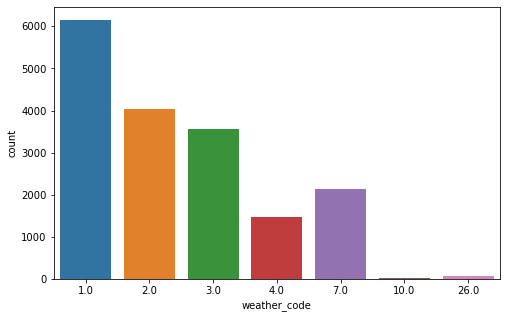

In [269]:
plt.figure(figsize = (8,5))
sns.countplot(x = "weather_code", data = df)
plt.show()

<Figure size 576x360 with 0 Axes>

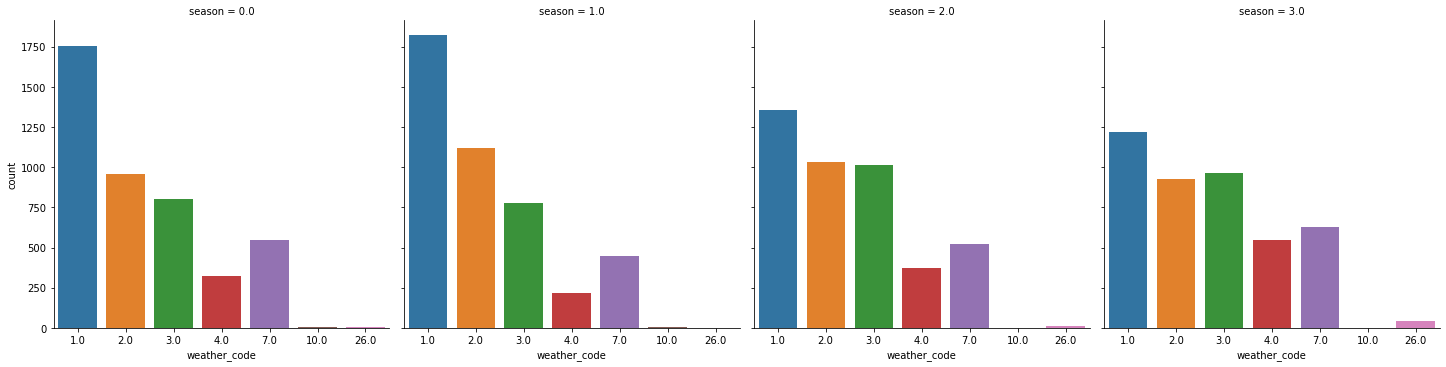

In [270]:
plt.figure(figsize = (8,5))
sns.catplot(x = "weather_code", col = "season", col_wrap = 4, data = df, kind = "count")
plt.show()

In [271]:
# Drop unnecessary columns
df.shape

(17414, 15)

In [272]:
drop_columns = ["t2","year_month"]
df.drop(drop_columns, axis = 1, inplace = True)

In [273]:
df.shape

(17414, 13)

In [274]:
df.head(1)

,cnt,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day_of_month,day_of_week,hour
timestamp,,,,,,,,,,,,,
2015-01-04,182,3.000,93.000,6.000,3.000,0.000,1.000,3.000,2015,1,4,6,0


In [275]:
df.columns

Index(['cnt', 't1', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season', 'year', 'month', 'day_of_month', 'day_of_week',
       'hour'],
      dtype='object')

In [276]:
df.describe()

,cnt,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day_of_month,day_of_week,hour
count,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000,17414.000
mean,1143.102,12.468,72.325,15.913,2.723,0.022,0.285,1.492,2015.508,6.515,15.752,2.993,11.513
std,1085.108,5.572,14.313,7.895,2.341,0.147,0.452,1.119,0.508,3.453,8.794,2.004,6.916
min,0.000,-1.500,20.500,0.000,1.000,0.000,0.000,0.000,2015.000,1.000,1.000,0.000,0.000
25%,257.000,8.000,63.000,10.000,1.000,0.000,0.000,0.000,2015.000,4.000,8.000,1.000,6.000
50%,844.000,12.500,74.500,15.000,2.000,0.000,0.000,1.000,2016.000,7.000,16.000,3.000,12.000
75%,1671.750,16.000,83.000,20.500,3.000,0.000,1.000,2.000,2016.000,10.000,23.000,5.000,18.000
max,7860.000,34.000,100.000,56.500,26.000,1.000,1.000,3.000,2017.000,12.000,31.000,6.000,23.000


In [277]:
df.weather_code = df.weather_code.map({1:'clear',2:'scattered_clouds',
                     3:'broken_cloud',4:'cloudy',
                     7:'light_rain',10:'rain_thunderstorm',26:'snowfall'})
df.weather_code 

timestamp
2015-01-04 00:00:00        broken_cloud
2015-01-04 01:00:00               clear
2015-01-04 02:00:00               clear
2015-01-04 03:00:00               clear
2015-01-04 04:00:00               clear
                             ...       
2017-01-03 19:00:00        broken_cloud
2017-01-03 20:00:00              cloudy
2017-01-03 21:00:00              cloudy
2017-01-03 22:00:00              cloudy
2017-01-03 23:00:00    scattered_clouds
Name: weather_code, Length: 17414, dtype: object

In [278]:
df.season = df.season.map({0:'spring',1:'summer',2:'fall',3:'winter'})
df.season

timestamp
2015-01-04 00:00:00    winter
2015-01-04 01:00:00    winter
2015-01-04 02:00:00    winter
2015-01-04 03:00:00    winter
2015-01-04 04:00:00    winter
                        ...  
2017-01-03 19:00:00    winter
2017-01-03 20:00:00    winter
2017-01-03 21:00:00    winter
2017-01-03 22:00:00    winter
2017-01-03 23:00:00    winter
Name: season, Length: 17414, dtype: object

In [279]:
df = pd.get_dummies(df, drop_first=True)

In [280]:
df.shape

(17414, 20)

In [281]:
df.head(1)

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,year,month,day_of_month,day_of_week,hour,weather_code_clear,weather_code_cloudy,weather_code_light_rain,weather_code_rain_thunderstorm,weather_code_scattered_clouds,weather_code_snowfall,season_spring,season_summer,season_winter
timestamp,,,,,,,,,,,,,,,,,,,,
2015-01-04,182,3.000,93.000,6.000,0.000,1.000,2015,1,4,6,0,0,0,0,0,0,0,0,0,1


In [282]:
drop_columns = ["year", "month", "day_of_month", "day_of_week"]
df.drop(drop_columns, axis = 1, inplace = True)
df.head(1)

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,hour,weather_code_clear,weather_code_cloudy,weather_code_light_rain,weather_code_rain_thunderstorm,weather_code_scattered_clouds,weather_code_snowfall,season_spring,season_summer,season_winter
timestamp,,,,,,,,,,,,,,,,
2015-01-04,182,3.000,93.000,6.000,0.000,1.000,0,0,0,0,0,0,0,0,0,1


In [283]:
df.shape

(17414, 16)

## 2. Data Pre-Processing


### Train - Test Split

Appropriately split the data for optimum training.

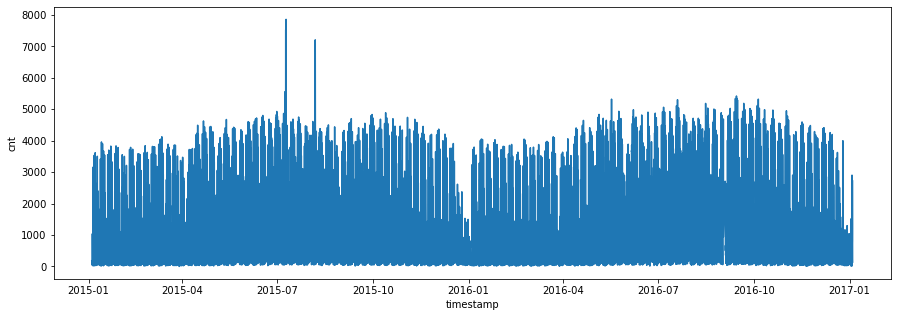

In [284]:
plt.figure(figsize=(15,5))
sns.lineplot(data = df, x = df.index, y = "cnt")

plt.show()

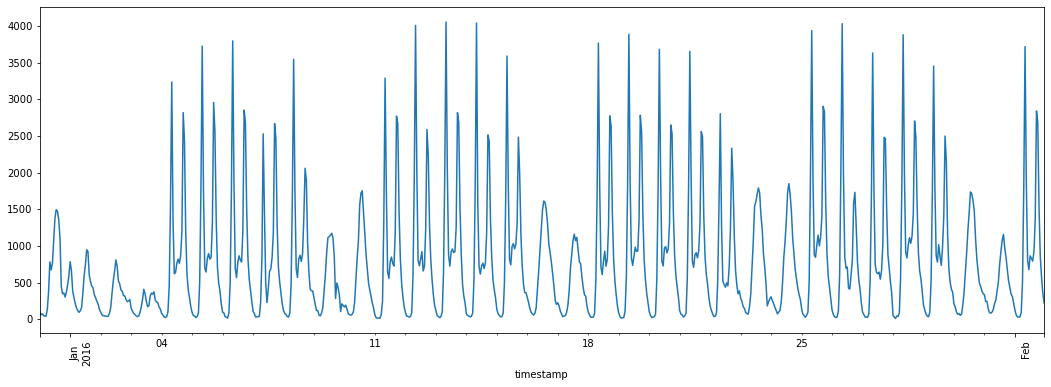

In [285]:
plt.figure(figsize=(15,5))
df['cnt'].loc["2015-12-31 00:00:00" : "2016-02-01 23:50:00"].plot(figsize=(18,6))
plt.xticks(rotation=90);

In [286]:
len(df)

17414

In [287]:
test_days = 60
test_ind = test_days*24
test_ind

1440

In [288]:
train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [289]:
train.shape, test.shape

((15974, 16), (1440, 16))

In [290]:
train.head(1)

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,hour,weather_code_clear,weather_code_cloudy,weather_code_light_rain,weather_code_rain_thunderstorm,weather_code_scattered_clouds,weather_code_snowfall,season_spring,season_summer,season_winter
timestamp,,,,,,,,,,,,,,,,
2015-01-04,182,3.000,93.000,6.000,0.000,1.000,0,0,0,0,0,0,0,0,0,1


In [291]:
test.head(1)

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,hour,weather_code_clear,weather_code_cloudy,weather_code_light_rain,weather_code_rain_thunderstorm,weather_code_scattered_clouds,weather_code_snowfall,season_spring,season_summer,season_winter
timestamp,,,,,,,,,,,,,,,,
2016-11-04 23:00:00,467,7.000,87.000,13.000,0.000,0.000,23,1,0,0,0,0,0,0,0,0


### Scaling

**Robust Scaling**

It is common to scale data prior to fitting a machine learning model.

This is because data often consists of many different input variables or features (columns) and each may have a different range of values or units of measure, such as feet, miles, kilograms, dollars, etc.

If there are input variables that have very large values relative to the other input variables, these large values can dominate or skew some machine learning algorithms. The result is that the algorithms pay most of their attention to the large values and ignore the variables with smaller values.

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. You can easily normalize the dataset using the Robust Scaling preprocessing class from the scikit-learn library.

- ***Note:*** *You are expected to scale only 't1'/'t2', 'hum', 'wind_speed' variables. You also need to scale the dependent and independent variables separately. You must do this for both train data and test data.*

In [292]:
from sklearn.preprocessing import RobustScaler

In [293]:
f_columns = ['t1', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())   # NİÇİN BURADA TO_NUMPY KULLANILDI
cnt_transformer = cnt_transformer.fit(train[['cnt']])   # TO_NUMPY BURADA NİÇİN KULLANILMADI. NİÇİN AYRI AYRI YAPILDI.

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [294]:
# columns = ['cnt', 't1', 'hum', 'wind_speed']

# transformer = RobustScaler()
# transformer = transformer.fit(train[columns])

# train.loc[:, columns] = transformer.transform(train[columns])
# test.loc[:, columns] = transformer.transform(test[columns])

In [295]:
train.head(3)

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,hour,weather_code_clear,weather_code_cloudy,weather_code_light_rain,weather_code_rain_thunderstorm,weather_code_scattered_clouds,weather_code_snowfall,season_spring,season_summer,season_winter
timestamp,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,-0.467,-1.250,0.975,-0.818,0.000,1.000,0,0,0,0,0,0,0,0,0,1
2015-01-04 01:00:00,-0.498,-1.250,0.975,-0.909,0.000,1.000,1,1,0,0,0,0,0,0,0,1
2015-01-04 02:00:00,-0.500,-1.312,1.150,-1.364,0.000,1.000,2,1,0,0,0,0,0,0,0,1


In [296]:
test.head(3)

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,hour,weather_code_clear,weather_code_cloudy,weather_code_light_rain,weather_code_rain_thunderstorm,weather_code_scattered_clouds,weather_code_snowfall,season_spring,season_summer,season_winter
timestamp,,,,,,,,,,,,,,,,
2016-11-04 23:00:00,-0.271,-0.750,0.675,-0.182,0.000,0.000,23,1,0,0,0,0,0,0,0,0
2016-11-05 00:00:00,-0.381,-0.812,0.675,-0.364,0.000,1.000,0,1,0,0,0,0,0,0,0,0
2016-11-05 01:00:00,-0.384,-0.875,0.675,-0.182,0.000,1.000,1,1,0,0,0,0,0,0,0,0


### Define a Function for Creating Time Steps 

In order to use the capabilities of LSTM, we need to organize the data in accordance with the working principles of LSTM.
You must separate the lines ordered by time in decimal steps.
The size of the step may vary depending on the situation, in this case it is set to 10.

Therefore, train and test data should be divided into groups of ten.
When predicting test data, the model is asked to use the information from the next 10 records with itself for each record.

As a result of this operation, each row will create a time step with the next 10 records, and you will have a matrix consisting of steps as many as the row total at the beginning.
So, your data set must be a 3-dimensional numpy array like (15662, 10,13).
As a result, LSTM will learn by taking 10 rows into account for one row.

Create a function, that takes two arguments: the dataset(dependent or independent variables separately), which is a NumPy array that we want to convert into a dataset, and the time_steps, which is the number of previous time steps to use as input variables to predict the next time period.

After defining the function, apply it to train and test sets.

In [297]:
def create_dataset(X, y, time_steps=1):
    """ Create data sequence
    
    Arguments:
        * X: time-series data
        * y: Count "cnt" value
        * time_steps: Used to create input sequence of timesteps
    
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys) #x = np.asarray(x).astype('float32').

In [298]:
time_steps = 24  # 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

(15950, 24, 16) (15950,)
(1416, 24, 16) (1416,)


---
---

## 3. Model Building with LSTM



##Recurrent Neural Networks 
RNN are a type of artifcial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, the spoken word, numerical times series data.

Recurrent Neural Networks use backpropagation algorithm for training. Because of their internal memory, RNN’s are able to remember important things about the input they received, which enables them to be very precise in predicting what’s coming next.

RNNs could be stacked up to deeper versions, which contain more than 1 layers of RNN. Because RNNs are especially computationally expensive to train, normally a deep RNN model contains no more than 3 layers of LSTM.

Train a bidirectional long short term memory (LSTM) recurrent neural network (RNN) with this data, making use of the self-loop and forget gate of LSTM.

LSTM sequential learning model was chosen because of its ability to process sequential data and memorize data of past time steps.

LSTM is a different type of gated RNN which is capable of learning long-term dependencies LSTM is not affected by vanishing gradient or exploding gradient problem
Using Bidirectional LSTMs, we feed the learning algorithm with the original data once from beginning to the end and once from end to beginning.

#### Bidirectional LSTM :
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem. Figure shows the mechanism of Bidirectional LSTM.






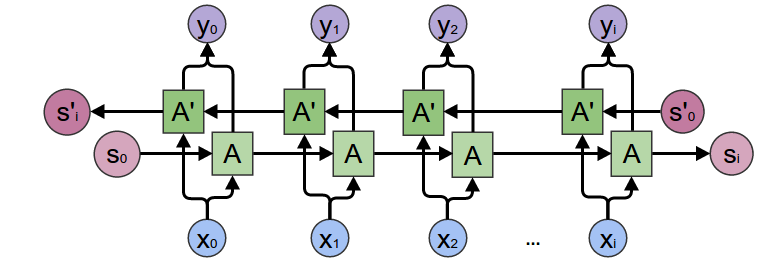

### Create, Compile and Fit Bidirectional LSTM Model

- Create a Sequential Model,
- Add Bidirectional layers,
- Apply Regularization (Drop Out),
- Compile the model.

***Note:*** *Define the optimizer as the efficient stochastic gradient descent algorithm ***adam***.* *This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.*

*In this case, use ***mean squared error*** as the loss argument. This loss is for a regression problems and is defined in Keras as mean_squared_error.
Also use defined in Keras as ***accuracy*** as the metrics.*

### Plot Train and Validation Losses

In [299]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [300]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]))))

model.add(Dropout(rate=0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [301]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [302]:
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=32, 
          validation_split=0.3,
          shuffle=False,
          callbacks=[early_stop])

Epoch 1/30
349/349 [==============================] - 15s 36ms/step - loss: 0.1817 - val_loss: 0.1084
Epoch 2/30
349/349 [==============================] - 13s 37ms/step - loss: 0.0675 - val_loss: 0.0626
Epoch 3/30
349/349 [==============================] - 12s 33ms/step - loss: 0.0431 - val_loss: 0.0500
Epoch 4/30
349/349 [==============================] - 11s 32ms/step - loss: 0.0343 - val_loss: 0.0448
Epoch 5/30
349/349 [==============================] - 14s 39ms/step - loss: 0.0299 - val_loss: 0.0383
Epoch 6/30
349/349 [==============================] - 14s 40ms/step - loss: 0.0258 - val_loss: 0.0314
Epoch 7/30
349/349 [==============================] - 15s 42ms/step - loss: 0.0238 - val_loss: 0.0344
Epoch 8/30
349/349 [==============================] - 17s 49ms/step - loss: 0.0215 - val_loss: 0.0293
Epoch 9/30
349/349 [==============================] - 13s 37ms/step - loss: 0.0215 - val_loss: 0.0306
Epoch 10/30
349/349 [==============================] - 14s 40ms/step - loss: 0.019

<AxesSubplot:>

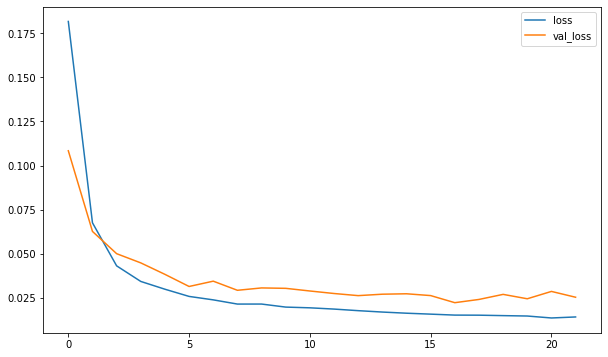

In [303]:
losses = pd.DataFrame(model.history.history)
losses.plot()

---
---

## 4. Demand Predictions and Calculate Scores

At this stage, you will measure the prediction success of your model. So, you will need to compare the actual values of the test data with their predicted values. 

For this reason, you must inverse transform the y_pred variable predicted by the model with the target variables of the train and test data you have previously scaled.

Check scores with both scaled results and inversed results

Plot predictions and actula values together

In [304]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [305]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [306]:
y_pred = model.predict(X_test)
y_pred

array([[-0.34934953],
       [-0.33658582],
       [-0.37488803],
       ...,
       [-0.27326304],
       [-0.35749674],
       [-0.43144542]], dtype=float32)

In [307]:
eval_metrics(y_test, y_pred)

r2_score: 0.9560780015034945 
 mae: 0.08167773968159905 
 mse: 0.016004608905184913 
 rmse: 0.12650932339232912


### Inverse Transform

In [310]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

In [366]:
len(y_train_inv)

1

In [365]:
len(y_test_inv)

1

In [364]:
len(y_pred_inv)

1416

In [ ]:
# test_index = df_dum.iloc[train_size:].iloc[time_steps:].index

# pred_test = pd.concat([pd.DataFrame(y_test_inv.reshape(-1, 1)),
#                        pd.DataFrame(y_pred_inv)], axis = 1)
# pred_test.columns=['test','prediction']
# pred_test.index = test_index

In [356]:
test_index = df.iloc[train.shape[0]:].iloc[time_steps:].index

pred_test = pd.concat([pd.DataFrame(y_test_inv.reshape(-1, 1)),
                       pd.DataFrame(y_pred_inv)], axis = 1)
pred_test.columns=['test','prediction']
pred_test.index = test_index

In [360]:
train.shape #[0]

(15974, 16)

In [361]:
test.shape

(1440, 16)

In [362]:
df.iloc[train.shape[0]:]

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,hour,weather_code_clear,weather_code_cloudy,weather_code_light_rain,weather_code_rain_thunderstorm,weather_code_scattered_clouds,weather_code_snowfall,season_spring,season_summer,season_winter
timestamp,,,,,,,,,,,,,,,,
2016-11-04 23:00:00,467,-0.750,0.675,-0.182,0.000,0.000,23,1,0,0,0,0,0,0,0,0
2016-11-05 00:00:00,308,-0.812,0.675,-0.364,0.000,1.000,0,1,0,0,0,0,0,0,0,0
2016-11-05 01:00:00,303,-0.875,0.675,-0.182,0.000,1.000,1,1,0,0,0,0,0,0,0,0
2016-11-05 02:00:00,190,-1.000,0.975,-0.182,0.000,1.000,2,1,0,0,0,0,0,0,0,0
2016-11-05 03:00:00,148,-1.000,0.825,-0.091,0.000,1.000,3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,-1.000,0.375,0.364,0.000,0.000,19,0,0,0,0,0,0,0,0,1
2017-01-03 20:00:00,541,-1.000,0.375,0.545,0.000,0.000,20,0,1,0,0,0,0,0,0,1
2017-01-03 21:00:00,337,-0.938,0.250,0.818,0.000,0.000,21,0,1,0,0,0,0,0,0,1


In [363]:
df.iloc[train.shape[0]:].iloc[time_steps:]

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,hour,weather_code_clear,weather_code_cloudy,weather_code_light_rain,weather_code_rain_thunderstorm,weather_code_scattered_clouds,weather_code_snowfall,season_spring,season_summer,season_winter
timestamp,,,,,,,,,,,,,,,,
2016-11-05 23:00:00,421,-1.000,-0.175,0.182,0.000,1.000,23,1,0,0,0,0,0,0,0,0
2016-11-06 00:00:00,342,-1.000,-0.175,0.409,0.000,1.000,0,1,0,0,0,0,0,0,0,0
2016-11-06 01:00:00,282,-1.000,-0.275,0.273,0.000,1.000,1,1,0,0,0,0,0,0,0,0
2016-11-06 02:00:00,182,-1.125,-0.050,0.364,0.000,1.000,2,1,0,0,0,0,0,0,0,0
2016-11-06 03:00:00,137,-1.125,-0.175,0.182,0.000,1.000,3,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,-1.000,0.375,0.364,0.000,0.000,19,0,0,0,0,0,0,0,0,1
2017-01-03 20:00:00,541,-1.000,0.375,0.545,0.000,0.000,20,0,1,0,0,0,0,0,0,1
2017-01-03 21:00:00,337,-0.938,0.250,0.818,0.000,0.000,21,0,1,0,0,0,0,0,0,1


In [352]:
y_test.shape

(1416,)

In [353]:
df.iloc[train.shape[0]:].iloc[time_steps:].index

DatetimeIndex(['2016-11-05 23:00:00', '2016-11-06 00:00:00',
               '2016-11-06 01:00:00', '2016-11-06 02:00:00',
               '2016-11-06 03:00:00', '2016-11-06 04:00:00',
               '2016-11-06 05:00:00', '2016-11-06 06:00:00',
               '2016-11-06 07:00:00', '2016-11-06 08:00:00',
               ...
               '2017-01-03 14:00:00', '2017-01-03 15:00:00',
               '2017-01-03 16:00:00', '2017-01-03 17:00:00',
               '2017-01-03 18:00:00', '2017-01-03 19:00:00',
               '2017-01-03 20:00:00', '2017-01-03 21:00:00',
               '2017-01-03 22:00:00', '2017-01-03 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=1416, freq=None)

In [354]:
pred_test

,test,prediction
timestamp,,
2016-11-05 23:00:00,421.000,353.244
2016-11-06 00:00:00,342.000,371.777
2016-11-06 01:00:00,282.000,316.163
2016-11-06 02:00:00,182.000,238.183
2016-11-06 03:00:00,137.000,148.136
...,...,...
2017-01-03 19:00:00,1042.000,1172.132
2017-01-03 20:00:00,541.000,670.987
2017-01-03 21:00:00,337.000,463.722


### Plot Prediction

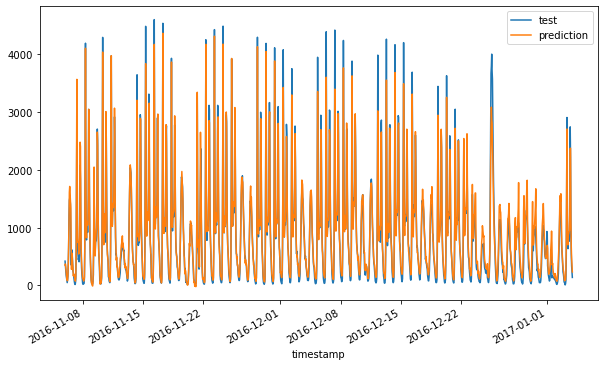

In [368]:
pred_test.plot();

In [371]:
pred_test.loc["2016-11-08 00:00:00" : "2016-11-15 23:50:00"]


,test,prediction
timestamp,,
2016-11-08 00:00:00,41.000,130.787
2016-11-08 01:00:00,20.000,112.090
2016-11-08 02:00:00,24.000,93.001
2016-11-08 03:00:00,35.000,76.504
2016-11-08 04:00:00,34.000,104.114
2016-11-08 05:00:00,121.000,145.387
2016-11-08 06:00:00,661.000,595.319
2016-11-08 07:00:00,2166.000,2097.082
2016-11-08 08:00:00,4188.000,4100.442


<Figure size 1296x432 with 0 Axes>

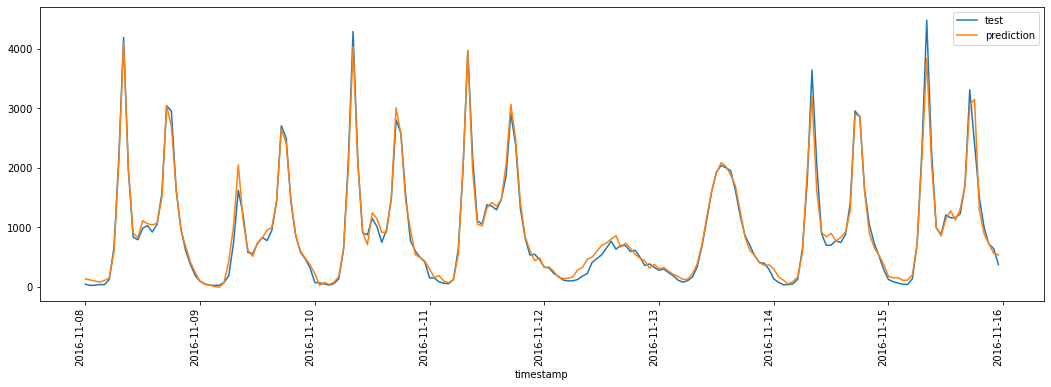

In [373]:
plt.figure(figsize=(18,6))
pred_test.loc["2016-11-08 00:00:00" : "2016-11-15 23:50:00"].plot(figsize=(18,6))
plt.xticks(rotation=90);

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___